<a href="https://colab.research.google.com/github/beom2pm/ds_edu_springFramework/blob/master/%EC%97%B4%EC%B2%98%EB%A6%AC_spc2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPC + 시계열


In [1]:
import pandas as pd

# 공정 raw 데이터
raw_df = pd.read_csv('raw_total_data.csv', encoding='utf-8', parse_dates=['TAG_MIN'])

# 불량 정보 라벨 데이터
label_df = pd.read_excel('label.xlsx')

##결측치 제거

In [2]:
# 필요없는 컬럼 제거 (빈 열이 있을 경우)
raw_df = raw_df.dropna(axis=1, how='all')

# 시간순 정렬
raw_df = raw_df.sort_values('TAG_MIN')

# 배정번호 기준으로 그룹핑
raw_df['배정번호'] = raw_df['배정번호'].astype(str)
label_df['배정번호'] = label_df['배정번호'].astype(str)

불량률 계산

In [3]:
label_df['불량률'] = label_df['불량수량'] / label_df['총수량']

배정번호 기준 집계


In [4]:
# raw 데이터에서 배정번호별 평균값 (센서 값 평균)
agg_df = raw_df.groupby('배정번호').mean().reset_index()

# 라벨 데이터와 병합
merged_df = pd.merge(agg_df, label_df[['배정번호', '불량률']], on='배정번호')

In [5]:
import numpy as np

def compute_spc_params(data, subgroup_size):
    subgroups = [data[i:i+subgroup_size] for i in range(0, len(data), subgroup_size) if len(data[i:i+subgroup_size]) == subgroup_size]
    subgroup_means = [np.mean(group) for group in subgroups]
    subgroup_ranges = [np.ptp(group) for group in subgroups]

    Xbar_bar = np.mean(subgroup_means)
    R_bar = np.mean(subgroup_ranges)

    # d2 계수: 그룹크기 5 → d2 ≈ 2.326 (표준 SPC 계수표에서)
    d2 = 2.326 if subgroup_size == 5 else 1.128  # 예시로 2/5 두 개만 씀

    sigma = R_bar / d2
    UCL = Xbar_bar + 3 * sigma
    LCL = Xbar_bar - 3 * sigma

    return subgroup_means, Xbar_bar, UCL, LCL

In [9]:
!apt -qq -y install fonts-nanum  #한국어 깨져서 적용

# 2. matplotlib에 한글 폰트 적용
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')  # or 'NanumGothicCoding'

# 3. 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


spc 차트


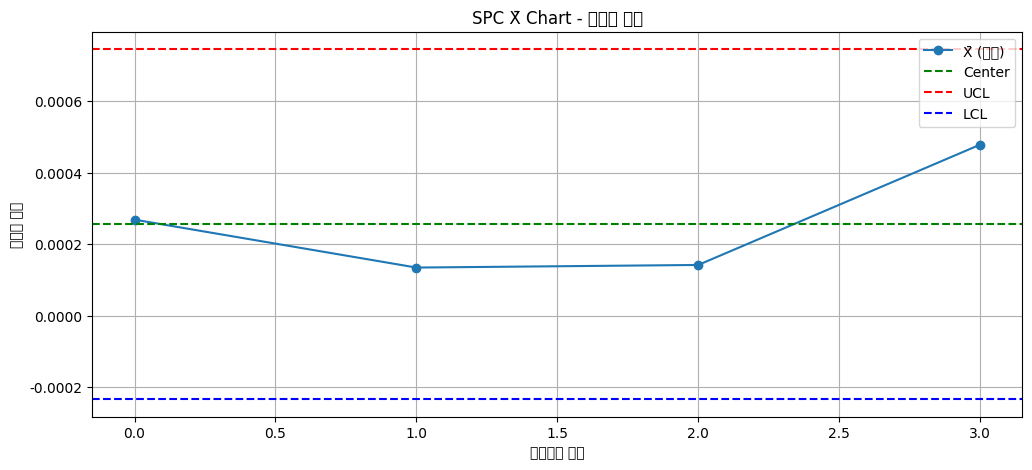

In [10]:
import matplotlib.pyplot as plt

# 불량률 시계열 기준
불량률_시계열 = merged_df.sort_values('배정번호')['불량률'].values

means, center, UCL, LCL = compute_spc_params(불량률_시계열, subgroup_size=5)

plt.figure(figsize=(12, 5))
plt.plot(means, marker='o', label='X̄ (평균)')
plt.axhline(center, color='green', linestyle='--', label='Center')
plt.axhline(UCL, color='red', linestyle='--', label='UCL')
plt.axhline(LCL, color='blue', linestyle='--', label='LCL')
plt.title('SPC X̄ Chart - 불량률 기준')
plt.xlabel('서브그룹 번호')
plt.ylabel('불량률 평균')
plt.legend()
plt.grid(True)
plt.show()